# Поиск задержек/отставаний в движении цен

In [121]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm, rc, dates
%matplotlib inline
from alex.database import Database
from pprint import pprint
import time

In [323]:
# stat packages
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf # функция расчёта автокорреляций
from statsmodels.graphics.tsaplots import plot_acf # визуализация автокорреляций
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера

## Загрузка данных

In [305]:
# загрузка истории
# 20 секунд
start = time.time()
db = Database()

sql_history = f"select (select exchange from mem.exchanges_pairs where id_ex_pair=h.id_ex_pair) exchange," \
              f"dt, price, amount, side " \
              f"from v_history h where location='memory' " \
              f"and id_ex_pair in (301,351,19,72,133,177,212) " \
              f"and dt>dateadd(hour,-3,getdate()) order by dt"
sql_history

"select (select exchange from mem.exchanges_pairs where id_ex_pair=h.id_ex_pair) exchange,dt, price, amount, side from v_history h where location='memory' and id_ex_pair in (301,351,19,72,133,177,212) and dt>dateadd(hour,-3,getdate()) order by dt"

In [308]:
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)
df_history.index = pd.to_datetime(df_history.index)
df_history.side = df_history.side.astype('category')
df_history.exchange = df_history.exchange.astype('category')
print(f"Loading time: {time.time()-start:.02f} sec")

Loading time: 5.85 sec


In [309]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36501 entries, 2018-10-29 11:42:42 to 2018-10-29 14:42:36
Data columns (total 4 columns):
exchange    36501 non-null category
price       36501 non-null float64
amount      36501 non-null float64
side        36501 non-null category
dtypes: category(2), float64(2)
memory usage: 927.2 KB


In [310]:
df_history.shape # (3037301, 4)

(36501, 4)

In [311]:
exchanges = df_history.exchange.unique().tolist()
exchanges

['binance', 'okex', 'hitbtc2', 'poloniex', 'bittrex', 'cryptopia', 'exmo']

In [348]:
freq = "1s"
df_binance = df_history[df_history.exchange=="binance"].resample(freq).agg({'price':'ohlc', 'amount':'sum'}).fillna(method='ffill')
df_okex = df_history[df_history.exchange=="okex"].resample(freq).agg({'price':'ohlc', 'amount':'sum'}).fillna(method='ffill')
#df_hitbtc2 = df_history[df_history.exchange=="hitbtc2"] #.resample("1s").agg("last")

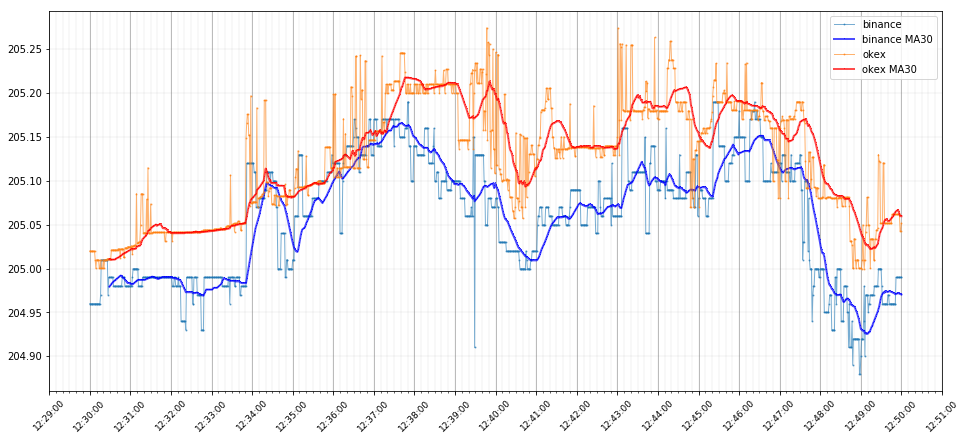

In [349]:
start = '2018-10-29 12:30:00'
end = '2018-10-29 12:50:00'
MA = 30

plt.rcParams['figure.figsize'] = [16, 7]

plt.plot(df_binance[start:end].price.close, marker='o', linewidth=1, label="binance", markersize=1, alpha=0.6)
plt.plot(df_binance[start:end].price.close.rolling(MA).mean(), 
         marker=',', linewidth=2, label=f"binance MA{MA}", markersize=1, color='blue', alpha=0.7)
plt.plot(df_okex[start:end].price.close, marker='o', linewidth=1, label="okex", markersize=1, alpha=0.6)
plt.plot(df_okex[start:end].price.close.rolling(MA).mean(), 
         marker=',', linewidth=2, label=f"okex MA{MA}", markersize=1, color='r', alpha=0.7)


ax = plt.gca()
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(dates.SecondLocator(interval=60))
ax.xaxis.set_minor_locator(dates.SecondLocator(interval=10))
ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)
ax.yaxis.grid(which='major', color='gray', linewidth=0.1)
ax.grid(True)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="center", size=9) 
plt.legend()
plt.show()

## Графики корреляций